# Melanoma Diagnoses

In [1]:
import os
import keras
import pandas
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import load_model

import get_results


Using TensorFlow backend.


### Import Images

In [2]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )
    return data

data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

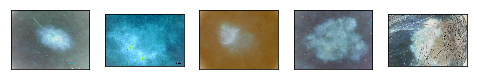

In [3]:
fig = plt.figure(figsize=(20,5))
train_files = os.listdir(train_dir+"/melanoma")[:5]
for i in range(5):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(load_image(train_dir + "/melanoma/" +train_files[i]))

### Image Data transformation

In [3]:
img_width, img_height = 256, 256
batch_size = 32
epochs = 5

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
    rotation_range=30)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    class_mode = "categorical")

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [5]:
train_generator.image_shape

(256, 256, 3)

### Fine-tune Model

In [ ]:
# create the base pre-trained model
vgg_model = applications.VGG19(weights = "imagenet", 
                           include_top=False, 
                           input_shape = (img_width, img_height, 3))
for layer in vgg_model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
# add fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(3, activation='softmax')(x)

model_final = Model(inputs=vgg_model.input, outputs=predictions)

# freeze pre-trained model area's layer
for layer in vgg_model.layers:
    layer.trainable = False

# update the weight that are added
model_final.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [ ]:
model_final.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size)

### Train Model

In [19]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("cancer_vgg19_1.h5", 
                             monitor='val_acc', verbose=2, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, patience=3, 
                      verbose=2, mode='auto')

# choose the layers which are updated by training
layer_num = len(model_final.layers)
for layer in model_final.layers[:21]:
    layer.trainable = False

for layer in model_final.layers[21:]:
    layer.trainable = True

# training
model_final.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model 
model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples/train_generator.batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples/validation_generator.batch_size,
    callbacks = [checkpoint, early])

Epoch 1/5
63/62 [==============================] - 340s - loss: 0.7611 - acc: 0.6964 - val_loss: 0.9823 - val_acc: 0.5533
Epoch 2/5
63/62 [==============================] - 287s - loss: 0.7639 - acc: 0.6805 - val_loss: 0.9956 - val_acc: 0.5333
Epoch 3/5
63/62 [==============================] - 294s - loss: 0.7629 - acc: 0.6895 - val_loss: 0.9951 - val_acc: 0.5133
Epoch 4/5
63/62 [==============================] - 281s - loss: 0.7623 - acc: 0.6954 - val_loss: 1.0370 - val_acc: 0.5133
Epoch 5/5
63/62 [==============================] - 295s - loss: 0.7561 - acc: 0.6895 - val_loss: 1.0232 - val_acc: 0.5133
Epoch 00004: early stopping


In [26]:
model_final.save('vgg19_model.h5')

In [4]:
model_final = load_model('vgg19_model.h5')

In [ ]:
img_path = 'data/test/nevus/ISIC_0012803.jpg'
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = test_datagen.standardize(x)
model_final.load_weights('cancer_vgg19_1.h5')
model_final.predict(x, verbose=2)

In [10]:
img_path = 'data/test/melanoma/ISIC_0012989.jpg'
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = test_datagen.standardize(x)
model_final.load_weights('cancer_vgg19_1.h5')
model_final.predict(x, verbose=2)

array([[ 0.14774518,  0.70521778,  0.14703698]], dtype=float32)

In [9]:
img_path = 'data/test/seborrheic_keratosis/ISIC_0012323.jpg'
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = test_datagen.standardize(x)
model_final.load_weights('cancer_vgg19_1.h5')
model_final.predict(x, verbose=2)

array([[ 0.18339969,  0.6124844 ,  0.20411593]], dtype=float32)

In [ ]:
model_final.evaluate_generator(test_generator, 
                               steps = test_generator.samples/test_generator.batch_size)